<a href="https://colab.research.google.com/github/rp-bot/audio-sentiment-analysis/blob/main/audio_sentiment_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
home_dir = "/content/drive/MyDrive/Colab Notebooks/audio_sentiment_analysis"
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt


# Neural Network Stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

## Setting up the dataset

In [6]:
# Define the directory containing your audio files
audio_dir = os.path.join(home_dir, 'data')
output_dir = os.path.join(home_dir, 'output_samples')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [7]:
# Define target sampling rate and duration for each sample
target_sr = 16000  # Target sampling rate of 16 kHz
sample_duration = 2.0  # Duration of each sample in seconds

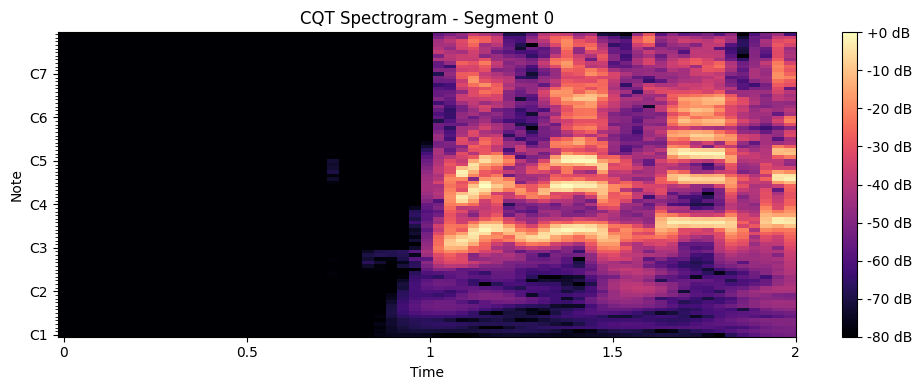

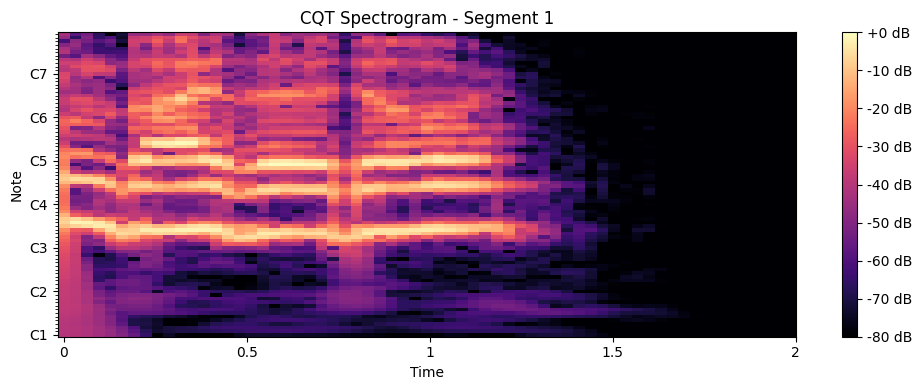

Spectrogram generation complete.


In [19]:
def generate_cqt_spectrograms(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=target_sr)

    # Calculate number of samples per segment
    samples_per_segment = int(target_sr * sample_duration)
    num_segments = int(len(y) / samples_per_segment)

    for i in range(num_segments):
        start_sample = i * samples_per_segment
        end_sample = start_sample + samples_per_segment

        # Extract segment
        segment = y[start_sample:end_sample]

        # Generate CQT spectrogram
        cqt_spectrogram = librosa.cqt(segment, sr=sr, hop_length=512)
        cqt_db = librosa.amplitude_to_db(np.abs(cqt_spectrogram), ref=np.max)

        # Save or display spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(cqt_db, sr=sr, x_axis='time', y_axis='cqt_note')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'CQT Spectrogram - Segment {i}')
        plt.tight_layout()

        # Save plot as image file
        output_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_segment_{i}.png"
        plt.savefig(os.path.join(output_dir, output_filename))
        plt.show()
        plt.close()

# Process each audio file in the directory
for filename in os.listdir(audio_dir):
    if filename.endswith('.mp3') or filename.endswith('.wav'):
        file_path = os.path.join(audio_dir, filename)
        generate_cqt_spectrograms(file_path)

print("Spectrogram generation complete.")

## Model

In [15]:
# CNN-4 Model Mentioned in the paper about emotion classification in movies
# (Lucia-Mulas et al. 2023)
class CNN4Model(nn.Module):
    def __init__(self):
        super(CNN4Model, self).__init__()

        # Define convolutional layers with Batch Normalization and MaxPooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Additional convolutional layers for more depth
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully connected layer
        self.fc1 = nn.Linear(256 * 10 * 10, 512)  # Adjust dimensions based on input size
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 4)  # Output layer for 4 emotions

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x

# Instantiate the model
model = CNN4Model()

# Print model architecture
print(model.parameters)

<bound method Module.parameters of CNN4Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25600, out_features=512, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)>
